In [3]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/JanWasilewski/Tensorflow_probability/master/data/Brazil_covid_data.csv')

In [4]:
data

,data,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,2/25/2020,0,0,0,0,NaN,NaN
1,2/26/2020,1,1,0,0,NaN,NaN
2,2/27/2020,1,0,0,0,NaN,NaN
3,2/28/2020,1,0,0,0,NaN,NaN
4,2/29/2020,2,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...
200,9/12/2020,4315687,33523,131210,814,3553421.0,631056.0
201,9/13/2020,4330455,14768,131625,415,3573958.0,624872.0
202,9/14/2020,4345610,15155,132006,381,3613184.0,600420.0
203,9/15/2020,4382263,36653,133119,1113,3671128.0,578016.0


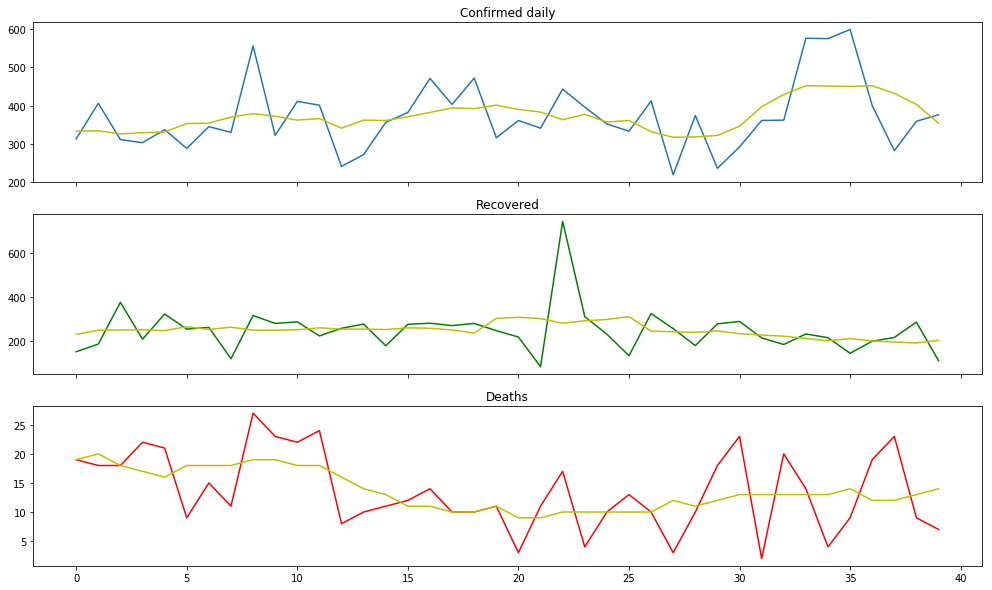

In [ ]:
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data to train SEID-RDe model 
data = data_df.fillna(0)

data_train = data.iloc[:40,:]
N_data_train = data_train.shape[0]

R_obs_w = np.round(np.array(data_train["Confirmed daily"]))
O_obs_w = np.round(np.array(data_train["Recovered"]))
Z_obs_w = np.round(np.array(data_train["Official deaths daily"]))

R_obs_SEIR = R_obs_w.copy()
O_obs_SEIR = O_obs_w.copy()
Z_obs_SEIR = Z_obs_w.copy()

for j in range(len(R_obs_w)):
    R_obs_SEIR[j] = round(sum(R_obs_w[max(j-3,0):min(j+4, len(R_obs_w))])/len(R_obs_w[max(j-3,0):min(j+4, len(R_obs_w))]))
    O_obs_SEIR[j] = round(sum(O_obs_w[max(j-3,0):min(j+4, len(O_obs_w))])/len(O_obs_w[max(j-3,0):min(j+4, len(O_obs_w))]))
    Z_obs_SEIR[j] = round(sum(Z_obs_w[max(j-3,0):min(j+4, len(Z_obs_w))])/len(Z_obs_w[max(j-3,0):min(j+4, len(Z_obs_w))]))
      
# number of days to forecast
N_predict = 200

fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data_train), R_obs_w)
axes[0].plot(range(N_data_train), R_obs_SEIR, "y")
axes[0].set_title('Confirmed daily')
axes[1].plot(range(N_data_train), O_obs_w,"g")
axes[1].plot(range(N_data_train), O_obs_SEIR, "y")
axes[1].set_title('Recovered')
axes[2].plot(range(N_data_train), Z_obs_w, "r" )
axes[2].plot(range(N_data_train), Z_obs_SEIR, "y")
axes[2].set_title('Deaths')
plt.show()

## Bayesian SEIR trend analysis

In [ ]:
# number of samples in MCMC
N_samples = 1e5
#N_samples = 10

In [ ]:
# Differential equation system
from functools import reduce
from scipy.integrate import odeint

def system(y, t, beta, sigma, gamma, delta, ni):
    Sw, Ew, Iw, Rw, Ow, Zw = y
    dydt = [-np.exp(beta) * Iw * Sw,
            np.exp(beta) * Iw * Sw - np.exp(sigma) * Ew,
            np.exp(sigma) * Ew - np.exp(gamma) * Iw,
            np.exp(gamma) * Iw - (np.exp(delta) + np.exp(ni)) * Rw,
            np.exp(delta) * Rw,
            np.exp(ni) * Rw]
    return dydt

def Rw_solution(y0, beta, sigma, gamma, delta, ni, t = np.linspace(0, N_data_train, num = N_data_train + 1)):
    solution = odeint(system, y0, t, args=(beta, sigma, gamma, delta, ni))
    R_change = solution[1: ,3] - solution[:len(solution) - 1, 3]
    Z_change = solution[1: ,5] - solution[:len(solution) - 1, 5]
    O_change = solution[1: ,4] - solution[:len(solution) - 1, 4]
    return R_change + O_change + Z_change, Z_change, O_change

In [ ]:
# SEIR initial values
SEIR_init = np.array([35979104, 1081, 5777, 14037, 0, 0])
N = sum(SEIR_init)
# max(SEIR_init) = 1 for the Rw_solution solusion stability
SEIR_init_norm = SEIR_init / N
  
tfd = tfp.distributions

# Define join probability

# params = [beta, gamma, sigma, delta, eta]
def joint_log_prob(params, R_obs_SEIR = R_obs_SEIR, O_obs_SEIR = O_obs_SEIR,
                   Z_obs_SEIR = Z_obs_SEIR, SEIR_init_norm = SEIR_init_norm):
            
    prior = tf.cast(tfd.MultivariateNormalDiag(loc = [np.log(1/5), np.log(1/5), np.log(1/3.5),
                                            np.log(1/60), np.log(1/800)], scale_diag = [100]*5).log_prob(params), 'float32')
    
    
    # hyperpriors
    sigma_R = 100
    sigma_Z = 25
    sigma_O = 100

       
    R_SEIR, Z_SEIR, O_SEIR =  Rw_solution(SEIR_init_norm, beta = params[0][0], gamma = params[0][1],
                                          sigma = params[0][2], delta = params[0][3], ni = params[0][4])
    
    # Scale back
    R_SEIR = tf.Variable(N * R_SEIR, dtype = tf.float32)
    Z_SEIR = N * Z_SEIR
    O_SEIR = N * O_SEIR

    likelihood_R = tfd.NegativeBinomial(probs = 1 - R_SEIR/(R_SEIR + sigma_R),
                                                 total_count = tf.Variable((R_SEIR**2)/(sigma_R), dtype = "float32")).log_prob(R_obs_SEIR)
    likelihood_Z = tfd.NegativeBinomial(probs = tf.Variable(1 - Z_SEIR/(Z_SEIR + sigma_Z), dtype = "float32"),
                                                 total_count = tf.Variable((Z_SEIR**2)/(sigma_Z), dtype = "float32")).log_prob(Z_obs_SEIR)
     
    likelihood_O = tfd.NegativeBinomial(probs = tf.Variable(1 - O_SEIR/(O_SEIR + sigma_O), dtype = "float32"),
                                                 total_count = tf.Variable((O_SEIR**2)/(sigma_O), dtype = "float32")).log_prob(O_obs_SEIR)
         
    return prior + sum(likelihood_O) + sum(likelihood_Z) + sum(likelihood_R) 

In [ ]:
# Sampling
hmc = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=joint_log_prob,
        seed = 1)

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results = int(N_samples),
    num_burnin_steps = int(0.3*N_samples),
    current_state = tf.constant([np.log(1/5), np.log(1/5), np.log(1/5),
                                 np.log(1/3.5), np.log(1/60)],
                                shape = (1,5)),
    kernel=hmc)

sample = samples[:,0,:]

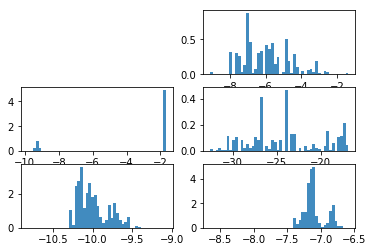

In [ ]:
# Plot posterior distributions

for i in range(5):    
    ax = plt.subplot(3, 2, i + 2)
    plt.hist(tf.reshape(sample[:,i], (-1,)).numpy(), histtype = 'stepfilled', bins = 50, alpha = 0.85,
             label = None, density = True)

In [ ]:
# Bayesian prediction 
trend_sample = []
for i in range(int(N_samples)):
    R_SEIR, Z_SEIR, O_SEIR = Rw_solution(SEIR_init_norm,
                             beta = sample[i, 0],
                             gamma = sample[i, 1],
                             sigma = sample[i, 2],
                             delta = sample[i, 3],
                             ni = sample[i, 4],
                             t = np.linspace(0, N_data_train + N_predict, num = N_data_train + N_predict + 1))
    R_SEIR = R_SEIR * N
    Z_SEIR = Z_SEIR * N
    O_SEIR = O_SEIR * N
    
    trend_sample.append(np.array([R_SEIR, Z_SEIR, O_SEIR]))

In [ ]:
# means and standard deviations of result distributions
trend = np.mean(np.array(trend_sample), axis = 0)
trend_std = np.std(np.array(trend_sample), axis = 0)

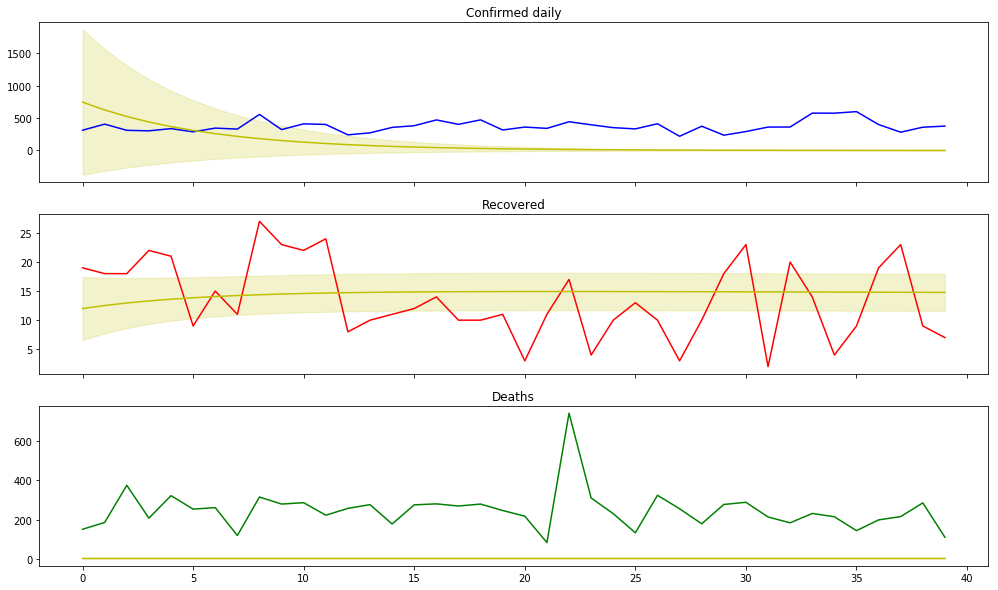

In [ ]:
# SEIR for trend - plots
fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data_train), R_obs_w, "b")
axes[0].plot(range(N_data_train), trend[0, :N_data_train], color="y")
axes[0].fill_between(range(N_data_train),
                     trend[0, :N_data_train] + 3 * trend_std[0, :N_data_train],
                     trend[0, :N_data_train] - 3 * trend_std[0, :N_data_train],
                     alpha=0.2, color="y")
axes[0].set_title('Confirmed daily')

axes[1].plot(range(N_data_train), Z_obs_w, "r" )
axes[1].plot(range(N_data_train), trend[1, :N_data_train], color="y")
axes[1].fill_between(range(N_data_train),
                     trend[1, :N_data_train] + 3 * trend_std[1, :N_data_train],
                     trend[1, :N_data_train] - 3 * trend_std[1, :N_data_train],
                     alpha=0.2, color="y")

axes[1].set_title('Recovered')

axes[2].plot(range(N_data_train), O_obs_w,"g")
axes[2].plot(range(N_data_train), trend[2, :N_data_train], color="y")
axes[2].fill_between(range(N_data_train),
                     trend[2, :N_data_train] + 3 * trend_std[2, :N_data_train],
                     trend[2, :N_data_train] - 3 * trend_std[2, :N_data_train],
                     alpha=0.2, color="y")

axes[2].set_title('Deaths')

plt.show()